In [66]:
import sklearn
from sklearn.datasets import make_circles
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from torch import nn
torch.__version__

'1.12.1+cu102'

## 1.0 Generating Data

In [67]:
n_samples = 1000

X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

In [68]:
len(X), len(y)

(1000, 1000)

In [69]:
print(f"First five features of X:\n {X[:5]}")
print(f"First five features of y:\n {y[:5]}")

First five features of X:
 [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First five features of y:
 [1 1 1 1 0]


In [70]:
# Making a dataframe with the circles data
circles = pd.DataFrame({"X1": X[:, 0],
                        "X2": X[:, 1],
                        "label": y})
circles.head()

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


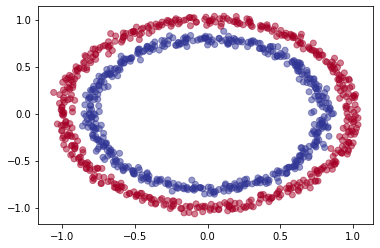

In [71]:
plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y, 
            cmap=plt.cm.RdYlBu,
           alpha=0.5)
plt.show()

### 1.1 Check input and output shapes

In [72]:
X.shape, y.shape

((1000, 2), (1000,))

In [73]:
X_sample = X[0]
y_sample = y[0]

X_sample.shape, y_sample.shape

((2,), ())

### 1.2 Turn data into tensors and create train and test splits

In [74]:
torch.manual_seed(42)

#### Converting to Tensors

In [75]:
type(X), type(y)

(numpy.ndarray, numpy.ndarray)

In [76]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5], type(X)

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]),
 torch.Tensor)

#### Splitting dataset

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2,
                                                    random_state=42)

In [78]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

In [79]:
n_samples

1000

## 2.0 Building a model

### 2.1 Device agnostic code

In [80]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


### 2.2 Construct model

4 steps:
- 1. Subclass `nn.Module`
- 2. Create 2 `nn.Linear()` layers with input and output shapes acc. to data
- 3. Define `forward()` method
- 4. Instantiate an instance of model class and send to target `device`

In [81]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

(torch.Size([800, 2]),
 torch.Size([800]),
 torch.Size([200, 2]),
 torch.Size([200]))

In [82]:
# Step 1
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        # Step 2
        self.layer_1 = nn.Linear(in_features=2, out_features=5)
        self.layer_2 = nn.Linear(in_features=5, out_features=1)
        
        # Alternate: Sequential
        # self.two_linear_layers = nn.Sequential(
        #    nn.Linear(in_features=2, out_features=5),
        #    nn.Linear(in_features=5, out_features=1))
    
    # Step 3
    def forward(self, x):
        return self.layer_2(self.layer_1(x))
        # return self.two_linear_layers(x)

# Step 4
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [83]:
next(model_0.parameters()).device

device(type='cuda', index=0)

In [84]:
model_0.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188]], device='cuda:0')),
             ('layer_1.bias',
              tensor([0.6146, 0.1323, 0.5224, 0.0958, 0.3410], device='cuda:0')),
             ('layer_2.weight',
              tensor([[-0.0631,  0.3448,  0.0661, -0.2088,  0.1140]], device='cuda:0')),
             ('layer_2.bias', tensor([-0.2060], device='cuda:0'))])

In [85]:
# Make predictions
with torch.inference_mode():
    untrained_preds = model_0(X_test.to(device))

In [86]:
print(f"First 10 preds {torch.round(untrained_preds[:10])}")
print(f"First 10 labels {y_test[:10]}")

First 10 preds tensor([[-0.],
        [-0.],
        [-0.],
        [-0.],
        [-0.],
        [-0.],
        [-0.],
        [-0.],
        [-0.],
        [-0.]], device='cuda:0')
First 10 labels tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


### 2.3 Setup loss function and optimiser, evaluation metric

In [87]:
LR = 0.01

loss_fn = nn.BCEWithLogitsLoss() # has the sigmoid activation function built in
                              # more stable than nn.BCELoss
optimiser = torch.optim.SGD(params=model_0.parameters(),
                             lr=LR)

In [88]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred). sum().item()
    acc = (correct/len(y_pred))*100
    return acc

## 3. Train 

- Forward pass
- Calculate the loss
- Optimiser zero grad
- Backward loss
- Optimiser step

### 3.1 Going from raw logits -> prediction probabilities -> prediction labels

In [223]:
# Viewing the logits which is the output of the model
with torch.inference_mode():
    y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.1269],
        [-0.0967],
        [-0.1908],
        [-0.1089],
        [-0.1667]], device='cuda:0')

In [224]:
# Using sigmoid activation function on model logits to turn them to probabilities
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.4683],
        [0.4758],
        [0.4524],
        [0.4728],
        [0.4584]], device='cuda:0')

In [225]:
# Finally, rounding them off to get the labels
torch.round(y_pred_probs)

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:0')

In [226]:
# putting it together:
with torch.inference_mode():
    y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device)[:5])))

In [227]:
y_pred_labels.squeeze()

tensor([0., 0., 0., 0., 0.], device='cuda:0')

### 3.2 Bilding a training and testing loop

In [228]:
device

'cuda'

In [229]:
!nvidia-smi

Sun Feb 12 20:53:00 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
| N/A   43C    P0    24W /  N/A |   1654MiB /  5926MiB |      5%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [230]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

EPOCHS = 100

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

tot_test_loss = []
tot_test_acc = []
tot_train_loss = []
tot_train_acc = []

for epoch in range(EPOCHS):
    
    # Training
    model_0.train()
    
    # 1. Forward pass
    y_logits = model_0(X_train).squeeze() # NOTICE the squeeze here!
    y_pred = torch.round(torch.sigmoid(y_logits))
    
    # 2. Calculate loss/accuracy
    loss = loss_fn(y_logits, y_train) # Since the loss function is BCE with logits loss, 
                                      # you don't have to apply sigmoid again!
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)
    
    # 3. Optimiser zero grad
    optimiser.zero_grad()
    
    # 4. Loss backward
    loss.backward()
    
    # 5. Optimiser step
    optimiser.step()
    
    tot_train_loss.append(loss)
    tot_train_acc.append(acc)
        
    ## Testing 
    model_0.eval()
    with torch.inference_mode():
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_test, test_pred)
        
        tot_test_loss.append(test_loss)
        tot_test_acc.append(test_acc)
        
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss} | Acc: {acc}| Test Loss: {test_loss} | Test Acc: {test_acc}")

Epoch: 0 | Loss: 0.6956853866577148 | Acc: 50.0| Test Loss: 0.697385311126709 | Test Acc: 50.0
Epoch: 10 | Loss: 0.6954386830329895 | Acc: 50.0| Test Loss: 0.6971977353096008 | Test Acc: 50.0
Epoch: 20 | Loss: 0.6952154636383057 | Acc: 50.0| Test Loss: 0.6970307230949402 | Test Acc: 50.0
Epoch: 30 | Loss: 0.6950134038925171 | Acc: 50.0| Test Loss: 0.6968820691108704 | Test Acc: 50.0
Epoch: 40 | Loss: 0.6948308348655701 | Acc: 50.0| Test Loss: 0.6967498660087585 | Test Acc: 50.0
Epoch: 50 | Loss: 0.6946654915809631 | Acc: 50.0| Test Loss: 0.6966323852539062 | Test Acc: 50.0
Epoch: 60 | Loss: 0.6945160031318665 | Acc: 50.0| Test Loss: 0.6965281367301941 | Test Acc: 50.0
Epoch: 70 | Loss: 0.6943807601928711 | Acc: 50.0| Test Loss: 0.6964356303215027 | Test Acc: 50.0
Epoch: 80 | Loss: 0.6942583322525024 | Acc: 50.0| Test Loss: 0.6963536143302917 | Test Acc: 50.0
Epoch: 90 | Loss: 0.6941476464271545 | Acc: 50.0| Test Loss: 0.6962809562683105 | Test Acc: 50.0


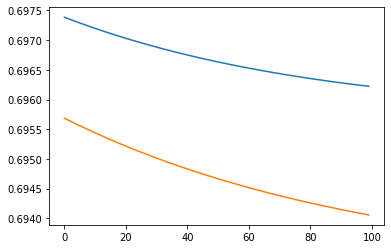

In [231]:
plt.plot(range(EPOCHS), np.array(torch.tensor(tot_test_loss).to('cpu')).squeeze())
plt.plot(range(EPOCHS), np.array(torch.tensor(tot_train_loss).to('cpu')).squeeze())

# 4.0 Making predictions and evaluating models

In [162]:
import requests
from pathlib import Path

if Path("helper_functions.py").is_file():
    print("already exists, skipping..")
else:
    url = "https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py"
    request = requests.get(url)
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)
        
from helper_functions import plot_predictions, plot_decision_boundary

already exists, skipping..


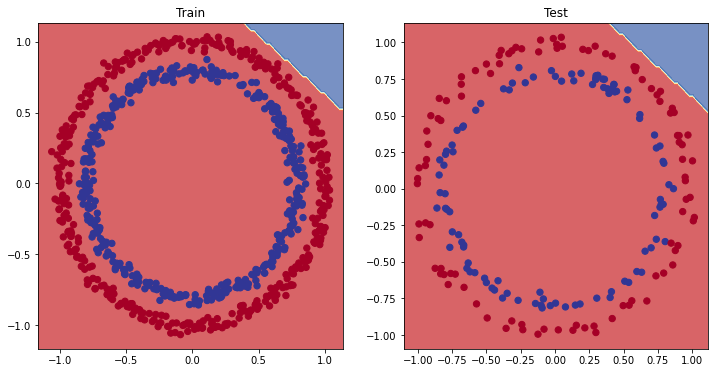

In [233]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

In [234]:
# The problem is the linear layers! 

## 4.1 Improivng the model

**Options**
- More layers
- More hidden units
- Train for longer
- Change activation functions
- Changing learning rate
- Changing the loss function

In [235]:
model_0.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[ 0.5407,  0.5869],
                      [-0.1665,  0.6493],
                      [-0.1551,  0.1426],
                      [-0.3438,  0.4154],
                      [ 0.6231, -0.5188]])),
             ('layer_1.bias',
              tensor([0.6130, 0.1424, 0.5246, 0.0897, 0.3444])),
             ('layer_2.weight',
              tensor([[-0.0471,  0.3486,  0.0816, -0.2056,  0.1229]])),
             ('layer_2.bias', tensor([-0.1769]))])

In [43]:
# Adding more layers, hidden units and epochs
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        
    def forward(self, x):
#         z = self.layer_1(x)
#         z = self.layer_2(z)
#         z = self.layer_3(z)
        return self.layer_3(self.layer_2(self.layer_1(x))) # SPEED UP BY NESTING!

model_1 = CircleModelV1().to(device)
# model_1.state_dict()
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [46]:
LR = 0.1
EPOCHS = 1000

# loss function
loss_fn = nn.BCEWithLogitsLoss()

# optimiser
optimiser = torch.optim.SGD(params=model_1.parameters(),
                            lr=LR)


# data on target device 
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(EPOCHS):
    
    # Training
    model_1.train()
    
    # 1. Forward pass
    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))
    
    # 2. Loss/Accuracy
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_train, y_pred)
    
    # 3. Optimiser zero grad
    optimiser.zero_grad()
    
    # 4. Backward loss
    loss.backward()
    
    # 5. Optimiser step
    optimiser.step()
    
    # Testing
    model_1.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        
        # 2. Test Loss
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_test, test_pred)
        
    # Print
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss} | Accuracy: {acc} | Test Loss: {test_loss} | Test Accuracy: {test_acc} |")

Epoch: 0 | Loss: 0.6991236805915833 | Accuracy: 51.24999999999999 | Test Loss: 0.7001092433929443 | Test Accuracy: 52.5 |
Epoch: 100 | Loss: 0.6930696964263916 | Accuracy: 50.0 | Test Loss: 0.6944203972816467 | Test Accuracy: 49.0 |
Epoch: 200 | Loss: 0.6929869055747986 | Accuracy: 51.125 | Test Loss: 0.6943963170051575 | Test Accuracy: 47.0 |
Epoch: 300 | Loss: 0.6929828524589539 | Accuracy: 51.5 | Test Loss: 0.6944564580917358 | Test Accuracy: 46.0 |
Epoch: 400 | Loss: 0.6929815411567688 | Accuracy: 51.5 | Test Loss: 0.6945081949234009 | Test Accuracy: 45.0 |
Epoch: 500 | Loss: 0.6929808855056763 | Accuracy: 51.37500000000001 | Test Loss: 0.6945487260818481 | Test Accuracy: 45.0 |
Epoch: 600 | Loss: 0.6929804086685181 | Accuracy: 51.24999999999999 | Test Loss: 0.6945798397064209 | Test Accuracy: 45.0 |
Epoch: 700 | Loss: 0.692980170249939 | Accuracy: 51.125 | Test Loss: 0.6946037411689758 | Test Accuracy: 45.5 |
Epoch: 800 | Loss: 0.6929800510406494 | Accuracy: 51.125 | Test Loss: 0.

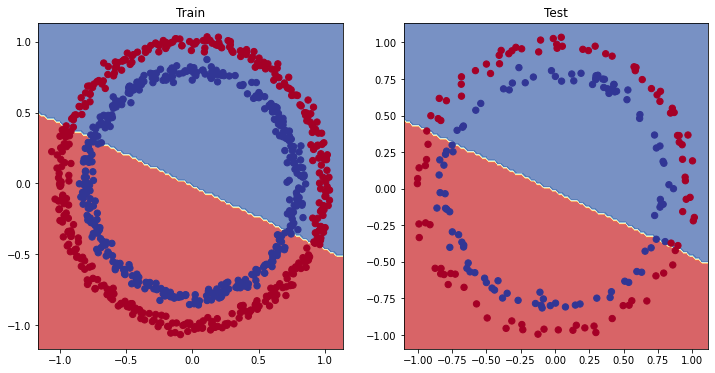

In [50]:
# Plot decision boundary
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

### 5.1 Preparing data to see if current model can fit a straight line

Troubleshooting: Test the model on a toy dataset

In [53]:
# Create some data

## Setting the weights
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

## Creating the data
X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias

## Visualising the data
print(len(X_regression))
X_regression[:5], y_regression[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [55]:
# Create train and test splits
train_split = int(0.8 * len(X_regression))
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]

len(X_train_regression), len(X_test_regression), len(y_train_regression), len(y_test_regression)

(80, 20, 80, 20)

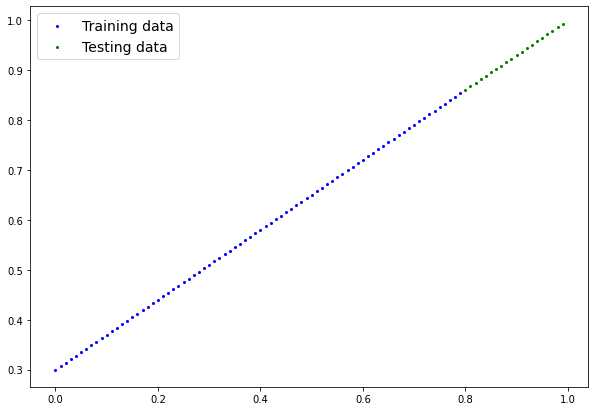

In [56]:
plot_predictions(train_data=X_train_regression,
                 train_labels=y_train_regression,
                 test_data=X_test_regression,
                 test_labels=y_test_regression)

In [57]:
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

### 5.2 Adjusting `model_1` to fit a straight line

In [68]:
# Same architechture as model_1, but with DIFFERENT input features!

model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10), 
    nn.Linear(in_features=10, out_features=10), 
    nn.Linear(in_features=10, out_features=1)).to(device)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [69]:
loss_fn_2 = nn.L1Loss()
optimiser_2 = torch.optim.SGD(params=model_2.parameters(),
                              lr=0.01)

In [70]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

EPOCHS = 1000

X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

for epoch in range(EPOCHS):
    
    # Training
    model_2.train()
    
    # Forward pass
    y_pred = model_2(X_train_regression)
    
    # Calculate the loss
    loss = loss_fn_2(y_pred, y_train_regression)
    
    # Optimiser zero grad
    optimiser_2.zero_grad()
    
    # Loss backward
    loss.backward()
    
    # Optimiser Step
    optimiser_2.step()
    
    # Testing
    model_2.eval()
    with torch.inference_mode():
        test_pred = model_2(X_test_regression)
        test_loss = loss_fn_2(test_pred, y_test_regression)
        
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss: .5f} | Test Loss: {test_loss: .5f} ")

Epoch: 0 | Loss:  0.75986 | Test Loss:  0.91103 
Epoch: 100 | Loss:  0.02858 | Test Loss:  0.00081 
Epoch: 200 | Loss:  0.02533 | Test Loss:  0.00209 
Epoch: 300 | Loss:  0.02137 | Test Loss:  0.00305 
Epoch: 400 | Loss:  0.01964 | Test Loss:  0.00341 
Epoch: 500 | Loss:  0.01940 | Test Loss:  0.00387 
Epoch: 600 | Loss:  0.01903 | Test Loss:  0.00379 
Epoch: 700 | Loss:  0.01878 | Test Loss:  0.00381 
Epoch: 800 | Loss:  0.01840 | Test Loss:  0.00329 
Epoch: 900 | Loss:  0.01798 | Test Loss:  0.00360 


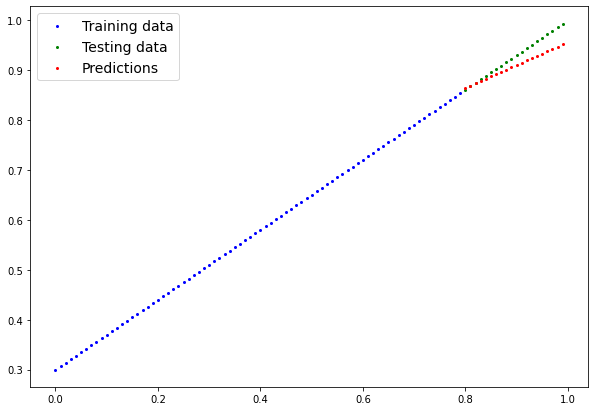

In [75]:
model_2.eval()
with torch.inference_mode():
    predictions_toy = model_2(y_test_regression)

plot_predictions(train_data=X_train_regression.cpu(),
                 train_labels=y_train_regression.cpu(),
                 test_data=X_test_regression.cpu(),
                 test_labels=y_test_regression.cpu(), 
                 predictions=predictions_toy.cpu())

So the model is capable of learning, must be the data then? 

The data that we are trying to learn is not linear!

## 6. The missing piece: Non-Linearity

### 6.1 Recreating non-linear data

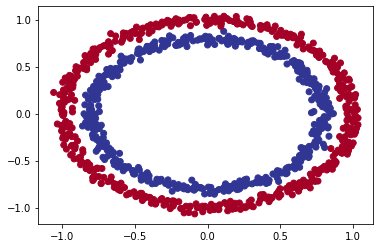

In [81]:
n_samples = 1000

X, y = make_circles(n_samples, 
                    noise=0.03, 
                    random_state=42)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu)
plt.show()

In [82]:
# convert data to tensors and then to train and test splits

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X_train, X_test, y_train, y_test = train_test_split(X, y)
len(X_train), len(X_test), len(y_train), len(y_test), 

(750, 250, 750, 250)

In [83]:
X_train[:5], y_train[:5]

(tensor([[-0.8381, -0.0271],
         [ 0.6318, -0.4518],
         [-0.2702,  0.7794],
         [-0.0206,  1.0024],
         [ 0.2866,  0.9797]]),
 tensor([1., 1., 1., 0., 0.]))

### 6.2 Building a model with non-linearity

In [128]:
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

In [129]:
model_3 = CircleModelV2().to(device)
model_3

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [130]:
LR = 0.1
EPOCHS = 1000

# loss function
loss_fn = nn.BCEWithLogitsLoss()

# optimiser 
optimiser = torch.optim.SGD(params=model_3.parameters(),
                            lr=0.1)

In [132]:
# seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# data to same device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(EPOCHS):
    
    # training
    model_3.train()
    
    # Forward pass
    y_logits = model_3(X_train).squeeze()
    y_preds = torch.round(torch.sigmoid(y_logits))
    
    # Calculate loss
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_train, y_preds)
    
    # Optimiser zero grad
    optimiser.zero_grad()
    
    # Loss backward
    loss.backward()
    
    # Optimiser step
    optimiser.step()
    
    # Testing
    model_3.eval()
    with torch.inference_mode():
        test_logits = model_3(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_test, test_pred)
        
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss: .3f} | Accuracy: {acc: .3f}% | Test Loss: {test_loss: .3f} | Test Accuracy: {test_acc: .3f} | ")
        
        

Epoch: 0 | Loss:  0.540 | Accuracy:  82.800% | Test Loss:  0.572 | Test Accuracy:  77.200 | 
Epoch: 100 | Loss:  0.485 | Accuracy:  84.667% | Test Loss:  0.521 | Test Accuracy:  78.800 | 
Epoch: 200 | Loss:  0.429 | Accuracy:  87.867% | Test Loss:  0.469 | Test Accuracy:  83.600 | 
Epoch: 300 | Loss:  0.293 | Accuracy:  97.600% | Test Loss:  0.310 | Test Accuracy:  95.200 | 
Epoch: 400 | Loss:  0.200 | Accuracy:  99.200% | Test Loss:  0.209 | Test Accuracy:  99.600 | 
Epoch: 500 | Loss:  0.144 | Accuracy:  99.467% | Test Loss:  0.150 | Test Accuracy:  99.600 | 
Epoch: 600 | Loss:  0.108 | Accuracy:  99.733% | Test Loss:  0.112 | Test Accuracy:  99.200 | 
Epoch: 700 | Loss:  0.087 | Accuracy:  99.733% | Test Loss:  0.090 | Test Accuracy:  99.200 | 
Epoch: 800 | Loss:  0.071 | Accuracy:  99.733% | Test Loss:  0.073 | Test Accuracy:  99.600 | 
Epoch: 900 | Loss:  0.060 | Accuracy:  99.733% | Test Loss:  0.062 | Test Accuracy:  99.600 | 


## 6.4 Evaluating a model trained with non-linear activation functions

In [133]:
model_3.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_3(X_test.to(device)))).squeeze()
y_preds[:5], y_test[:5]

(tensor([1., 0., 1., 0., 0.], device='cuda:0'),
 tensor([1., 0., 1., 0., 0.], device='cuda:0'))

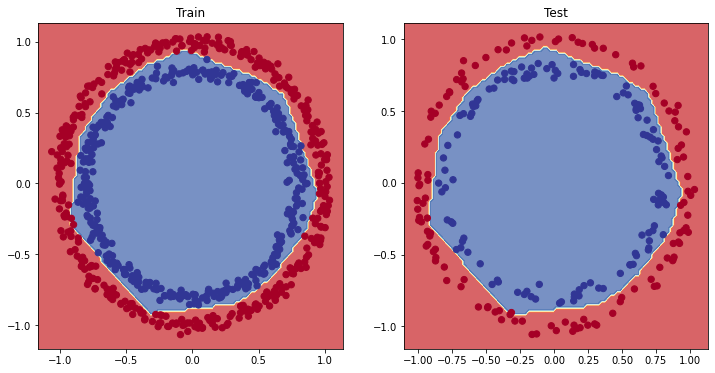

In [125]:
# Plot decision boundary
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_3, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test)

# 7. Replicatig non-linear activation functions

In [136]:
A = torch.arange(-10, 10, 1, dtype=torch.float32)
A.dtype

torch.float32

In [147]:
torch.relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

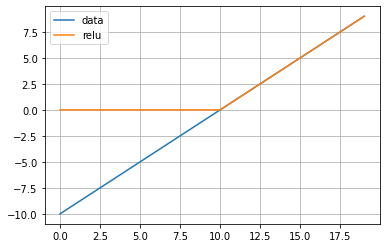

In [144]:
plt.plot(A, label='data')
plt.plot(torch.relu(A), label='relu')
plt.legend()
plt.grid()
plt.show()

In [149]:
# Implementing our own relu

def relu(x: torch.Tensor) -> torch.Tensor:
    return torch.maximum(torch.tensor(0), x)

relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

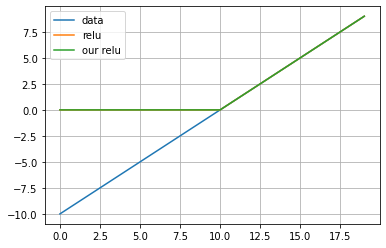

In [148]:
plt.plot(A, label='data')
plt.plot(torch.relu(A), label='relu')
plt.plot(relu(A), label='our relu')
plt.legend()
plt.grid()
plt.show()

In [151]:
# Implementing our own Sigmoid

def sigmoid(x: torch.Tensor) -> torch.Tensor:
    return 1 / (1 +torch.exp(-x))

sigmoid(A)

tensor([4.5398e-05, 1.2339e-04, 3.3535e-04, 9.1105e-04, 2.4726e-03, 6.6929e-03,
        1.7986e-02, 4.7426e-02, 1.1920e-01, 2.6894e-01, 5.0000e-01, 7.3106e-01,
        8.8080e-01, 9.5257e-01, 9.8201e-01, 9.9331e-01, 9.9753e-01, 9.9909e-01,
        9.9966e-01, 9.9988e-01])

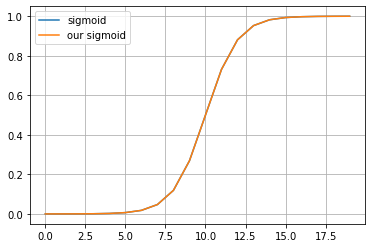

In [154]:
# plt.plot(A, label='data')
plt.plot(torch.sigmoid(A), label='sigmoid')
plt.plot(sigmoid(A), label='our sigmoid')
plt.legend()
plt.grid()
plt.show()

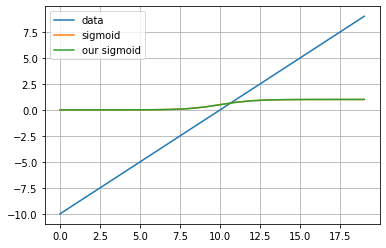

In [155]:
plt.plot(A, label='data')
plt.plot(torch.sigmoid(A), label='sigmoid')
plt.plot(sigmoid(A), label='our sigmoid')
plt.legend()
plt.grid()
plt.show()

## 8. Putting it all together with a multi-class classification problem

### 8.1 Creating a toy multi-class dataset

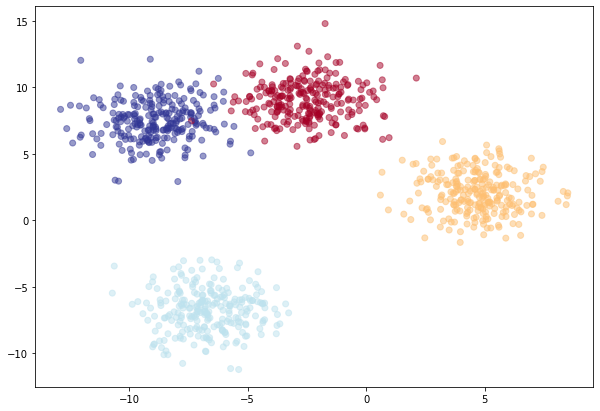

In [125]:
# Import dependencies
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set hyperparameters
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=NUM_FEATURES, 
                            centers=NUM_CLASSES,
                            cluster_std=1.5,
                            random_state=RANDOM_SEED)

# 2. Turn data into tensors 
# NOTICE that the datatype of the **labels** have to be LongTensor for CSELoss
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

# 3. Split into train and test
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(
                                                        X_blob, 
                                                        y_blob, 
                                                        test_size=0.2, 
                                                        random_state=RANDOM_SEED)

# 4. Plot data
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu, alpha=0.5)
plt.show()

In [126]:
X_blob[:5, 0], X_blob[:5, 1], y_blob[:5]

(tensor([-8.4134, -5.7665, -6.0421,  3.9508,  4.2505]),
 tensor([ 6.9352, -6.4312, -6.7661,  0.6984, -0.2815]),
 tensor([3, 2, 2, 1, 1]))

In [127]:
# Number of classes:
torch.unique(y_blob_train)

tensor([0, 1, 2, 3])

### 8.2 Building a multi-class classification model

In [128]:
# Create device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

Using device: cuda


In [144]:
# Build the model
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        """
        Initialises multi-class classification model.
        
        Args:
            input_features (int): Number of input features to the model
            output_features (int): Number of output features to the model
            hidden_units (int): Number of hidden units between layers, default is 8
            
        Returns:
        
        Example:
        """
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features))
        
    def forward(self, x):
        return self.linear_layer_stack(x)
    
model_4 = BlobModel(input_features=2, 
                    output_features=4, 
                    hidden_units=8,).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [145]:
X_blob_train.shape, y_blob_train[:5]

(torch.Size([800, 2]), tensor([1, 0, 2, 2, 0], device='cuda:0'))

### 8.3 Loss function and Optimiser

In [146]:
LR = 0.1

# Loss function 
loss_fn = nn.CrossEntropyLoss() # TO BALANCE THE DATASET, you use the weight parameter!

# Optimiser
optimiser = torch.optim.SGD(params=model_4.parameters(), 
                            lr=LR)

### 8.4 Getting initial prediction probabilities for the model

In [147]:
# Required:
y_blob_test[:5]

tensor([1, 3, 2, 1, 0], device='cuda:0')

8.4.1 Getting logits

In [148]:
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test.to(device))
    
y_logits[:5]

tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
        [-0.0973, -0.9431, -0.5963, -0.1371],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4134, -0.5204, -0.9303, -0.6963],
        [-0.3118, -1.3736, -1.1991, -0.3834]], device='cuda:0')

8.4.2 Converting to prediction probabilty

In [149]:
y_pred_prob = torch.softmax(y_logits, dim=1)
y_pred_prob[:5]

tensor([[0.3169, 0.3244, 0.1405, 0.2182],
        [0.3336, 0.1432, 0.2026, 0.3206],
        [0.3011, 0.1843, 0.2823, 0.2323],
        [0.3078, 0.2766, 0.1836, 0.2320],
        [0.3719, 0.1286, 0.1532, 0.3463]], device='cuda:0')

In [150]:
torch.sum(y_pred_prob[1]) # Because the probabilties sum to one

tensor(1.0000, device='cuda:0')

8.4.3 Converting to labels

In [151]:
y_preds = torch.argmax(y_pred_prob, dim=1)
y_preds[:5]

tensor([1, 0, 0, 0, 0], device='cuda:0')

### 8.5 Training loop and testing loop

In [152]:
# Set the seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
EPOCHS = 100

# Put data to the target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

In [153]:
# Training loop
for epoch in range(EPOCHS):
    
    # Training
    model_4.train()
    
    # 1. Forward pass
    y_logits = model_4(X_blob_train)
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # ARGMAX already takes the softmax. CHECK THAT OUT
    
    # 2. Calculate the loss
    loss = loss_fn(y_logits, y_blob_train)
    acc = accuracy_fn(y_true=y_blob_train, 
                      y_pred=y_pred)
    
    # 3. Optimiser zero grad
    optimiser.zero_grad()
    
    # 4. Loss backward
    loss.backward()
    
    # 5. Optimiser step
    optimiser.step()
    
    # Testing
    model_4.eval()
    with torch.inference_mode():
        test_logits = model_4(X_blob_test)
        test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)
        
        test_loss = loss_fn(test_logits, y_blob_test)
        test_acc = accuracy_fn(y_true=y_blob_test, y_pred=test_preds)
        
    # Print
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.4f} | Accuracy: {acc:.2f}% | Test Loss: {test_loss:.4f} | Accuracy: {test_acc}% | ")

Epoch: 0 | Loss: 1.1588 | Accuracy: 40.38% | Test Loss: 1.0755 | Accuracy: 48.0% | 
Epoch: 10 | Loss: 0.6448 | Accuracy: 96.75% | Test Loss: 0.6607 | Accuracy: 97.5% | 
Epoch: 20 | Loss: 0.4254 | Accuracy: 98.50% | Test Loss: 0.4307 | Accuracy: 100.0% | 
Epoch: 30 | Loss: 0.2529 | Accuracy: 99.12% | Test Loss: 0.2451 | Accuracy: 99.5% | 
Epoch: 40 | Loss: 0.1123 | Accuracy: 99.25% | Test Loss: 0.1023 | Accuracy: 99.5% | 
Epoch: 50 | Loss: 0.0663 | Accuracy: 99.25% | Test Loss: 0.0585 | Accuracy: 99.5% | 
Epoch: 60 | Loss: 0.0507 | Accuracy: 99.25% | Test Loss: 0.0429 | Accuracy: 99.5% | 
Epoch: 70 | Loss: 0.0430 | Accuracy: 99.25% | Test Loss: 0.0349 | Accuracy: 99.5% | 
Epoch: 80 | Loss: 0.0384 | Accuracy: 99.25% | Test Loss: 0.0299 | Accuracy: 99.5% | 
Epoch: 90 | Loss: 0.0352 | Accuracy: 99.25% | Test Loss: 0.0266 | Accuracy: 99.5% | 


#### Error we got:
`RuntimeError: "nll_loss_forward_reduce_cuda_kernel_2d_index" not implemented for 'Float'`


This is the problem with the data we created. The labels have to be `torch.LongTensor`, not `float`!

In [106]:
y_blob_train.dtype

torch.float32

### 8.6 Making and evaluating the predictions

In [161]:
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test)

y_preds = torch.softmax(y_logits, dim=1).argmax(dim=1)    
y_preds

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0, 0, 1, 0, 0, 0, 3, 3, 2, 3, 3, 3, 0, 1, 2,
        2, 2, 3, 0, 1, 0, 3, 1, 1, 3, 1, 2, 1, 3, 0, 2, 0, 3, 3, 2, 0, 3, 1, 1,
        0, 3, 1, 0, 1, 1, 3, 2, 1, 1, 3, 2, 2, 0, 3, 2, 2, 0, 0, 3, 3, 0, 0, 3,
        3, 3, 2, 3, 3, 3, 3, 1, 0, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3,
        1, 0, 3, 2, 0, 0, 3, 0, 2, 3, 1, 0, 3, 2, 1, 1, 0, 2, 2, 3, 0, 0, 1, 2,
        2, 3, 0, 1, 2, 0, 0, 0, 2, 3, 1, 2, 3, 2, 0, 3, 0, 0, 1, 1, 1, 0, 2, 2,
        2, 2, 0, 3, 0, 2, 2, 1, 3, 2, 0, 0, 3, 3, 2, 1, 2, 0, 3, 2, 0, 3, 2, 0,
        2, 2, 2, 0, 3, 1, 1, 1, 1, 1, 3, 1, 0, 2, 2, 1, 2, 2, 0, 1, 2, 2, 0, 0,
        1, 3, 2, 0, 3, 1, 2, 1], device='cuda:0')

In [160]:
y_blob_test

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0, 0, 1, 0, 0, 0, 3, 3, 2, 3, 3, 3, 0, 1, 2,
        2, 2, 3, 0, 1, 0, 3, 1, 1, 3, 1, 2, 1, 3, 0, 2, 0, 3, 3, 2, 0, 3, 1, 1,
        0, 3, 1, 0, 1, 1, 3, 2, 1, 1, 3, 2, 2, 0, 3, 2, 2, 0, 0, 3, 3, 0, 0, 3,
        3, 3, 2, 3, 3, 3, 3, 1, 0, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3,
        1, 0, 3, 2, 0, 0, 3, 0, 2, 3, 1, 0, 3, 2, 1, 1, 0, 2, 2, 3, 0, 0, 1, 2,
        2, 3, 0, 1, 2, 0, 0, 0, 2, 3, 1, 2, 3, 2, 0, 3, 0, 0, 1, 1, 1, 0, 2, 2,
        2, 2, 0, 3, 3, 2, 2, 1, 3, 2, 0, 0, 3, 3, 2, 1, 2, 0, 3, 2, 0, 3, 2, 0,
        2, 2, 2, 0, 3, 1, 1, 1, 1, 1, 3, 1, 0, 2, 2, 1, 2, 2, 0, 1, 2, 2, 0, 0,
        1, 3, 2, 0, 3, 1, 2, 1], device='cuda:0')

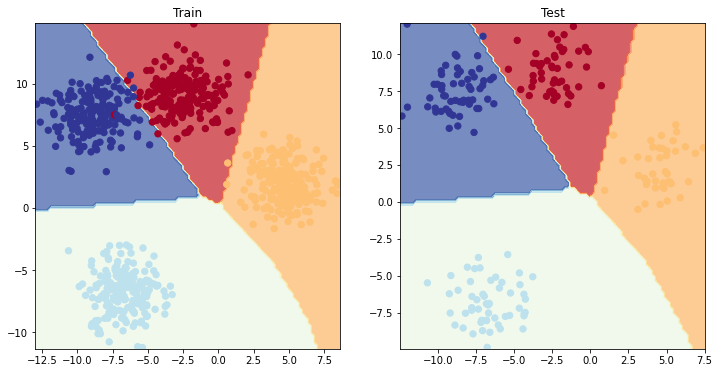

In [163]:
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

## 9. A few more classification metrics

1. Accuracy
2. Precision
3. Recall
4. F-1 score
5. Confusion matrix
6. Classification report

In [164]:
!pip install torchmetrics

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 517.2/517.2 kB 4.9 MB/s eta 0:00:004.6 MB/s eta 0:00:01

[notice] A new release of pip available: 22.3.1 -> 23.0
[notice] To update, run: python3 -m pip install --upgrade pip


In [173]:
from torchmetrics import Accuracy

# REMEMBER to put the metric as well on CUDA/CPU!!!
torchmetric_acc = Accuracy(task="multiclass", num_classes=4).to(device)
torchmetric_acc(y_preds, y_blob_test)

tensor(0.9950, device='cuda:0')

In [ ]:
## youtube video 14:00
## TO DO : EXCERSICES!